In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


In [2]:
train = pd.read_excel('train.xlsx')
test = pd.read_excel('test.xlsx')
print(train.shape)
print(test.shape)

(614, 13)
(367, 12)


In [3]:
data = pd.concat([train, test])
print(data.shape)

(981, 13)


In [4]:
data.drop('Loan_ID', axis=1, inplace=True)

In [5]:
data.isnull().sum()

Gender                24
Married                3
Dependents            25
Education              0
Self_Employed         55
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            27
Loan_Amount_Term      20
Credit_History        79
Property_Area          0
Loan_Status          367
dtype: int64

In [6]:
for i in [data]:
    i['Gender'] = i['Gender'].fillna(data.Gender.dropna().mode()[0])
    i['Married'] = i['Married'].fillna(data.Married.dropna().mode()[0])
    i['Dependents'] = i['Dependents'].fillna(data.Dependents.dropna().mode()[0])
    i['Self_Employed'] = i['Self_Employed'].fillna(data.Self_Employed.dropna().mode()[0])
    i['Credit_History'] = i['Credit_History'].fillna(data.Credit_History.dropna().mode()[0])

In [7]:
# data1 = data.loc[:, ['LoanAmount', 'Loan_Amount_Term']]

# imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)
# data1 = pd.DataFrame(imp.fit_transform(data1), columns=data1.columns)

data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(), inplace=True)

In [8]:
print(data.LoanAmount.isnull().sum())
print(data.Loan_Amount_Term.isnull().sum())

0
0


In [9]:
for i in [data]:
    i['Gender'] = i['Gender'].map({'Male': 0, 'Female': 1}).astype(int)
    i['Married'] = i['Married'].map({'No': 0, 'Yes': 1}).astype(int)
    i['Education'] = i['Education'].map({'Not Graduate': 0, 'Graduate': 1}).astype(int)
    i['Self_Employed'] = i['Self_Employed'].map({'No': 0, 'Yes': 1}).astype(int)
    i['Credit_History'] = i['Credit_History'].astype(int)

In [10]:
for i in [data]:
    i['Property_Area'] = i['Property_Area'].map({'Urban': 0, 'Rural': 1, 'Semiurban': 2}).astype(int)
    i['Dependents'] = i['Dependents'].map({0: 0, 1: 1, 2: 2, '3+': 3})

<AxesSubplot:xlabel='Dependents', ylabel='count'>

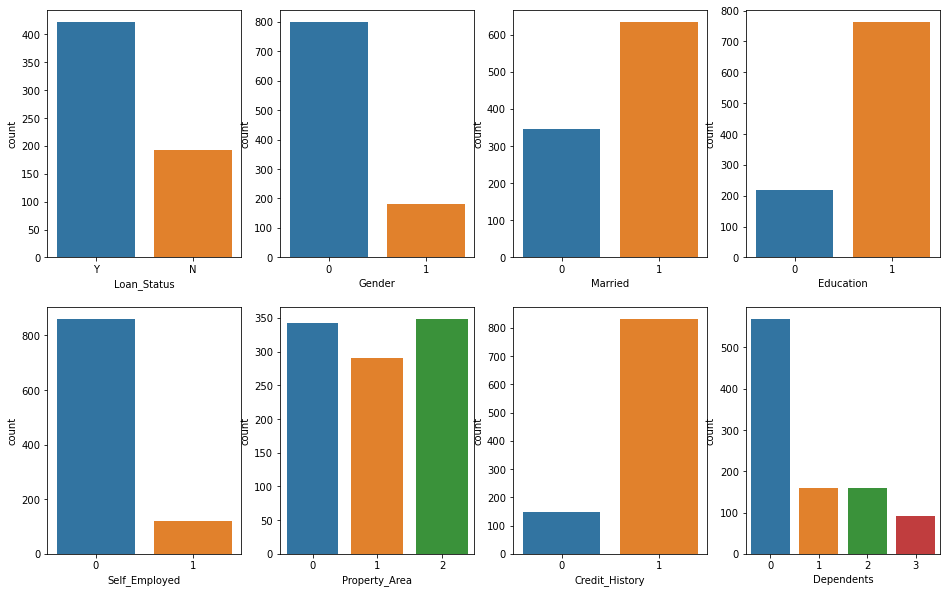

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(16, 10))

sns.countplot(x='Loan_Status', data=data, ax=ax[0][0])
sns.countplot(x='Gender', data=data, ax=ax[0][1])
sns.countplot(x='Married', data=data, ax=ax[0][2])
sns.countplot(x='Education', data=data, ax=ax[0][3])

sns.countplot(x='Self_Employed', data=data, ax=ax[1][0])
sns.countplot(x='Property_Area', data=data, ax=ax[1][1])
sns.countplot(x='Credit_History', data=data, ax=ax[1][2])
sns.countplot(x='Dependents', data=data, ax=ax[1][3])

<AxesSubplot:xlabel='Loan_Status', ylabel='ApplicantIncome'>

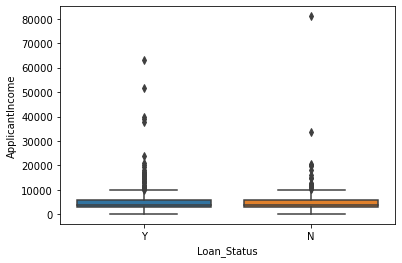

In [12]:
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=data)

<AxesSubplot:xlabel='Loan_Status', ylabel='CoapplicantIncome'>

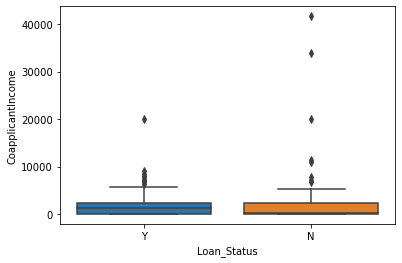

In [13]:
sns.boxplot(x='Loan_Status', y='CoapplicantIncome', data=data)

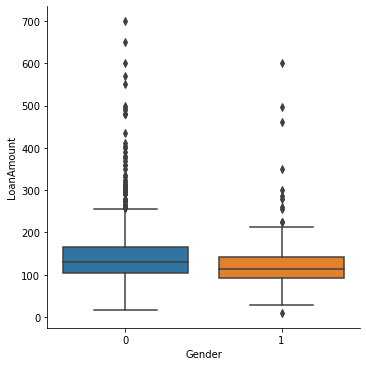

In [14]:
sns.catplot(x='Gender', y='LoanAmount', data=data, kind='box')

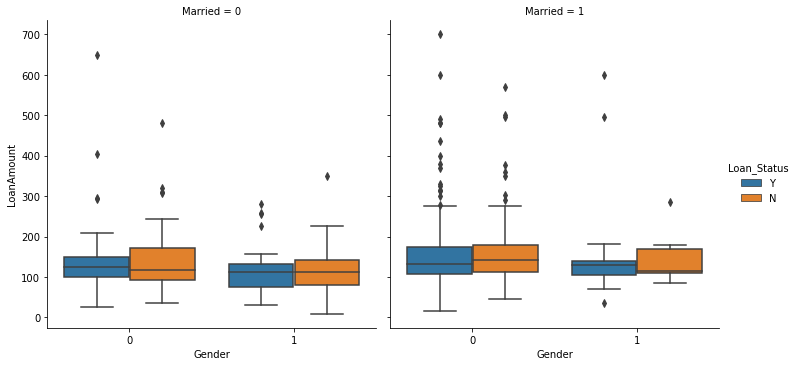

In [15]:
sns.catplot(x='Gender', y='LoanAmount', data=data, kind='box', hue='Loan_Status', col='Married')

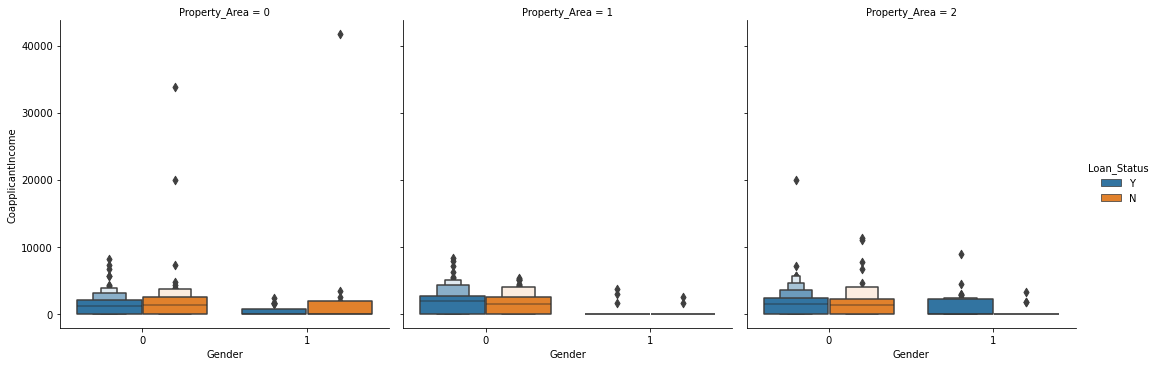

In [16]:
sns.catplot(x='Gender', y='CoapplicantIncome', data=data,kind='boxen', hue='Loan_Status', col='Property_Area')

<function matplotlib.pyplot.show(close=None, block=None)>

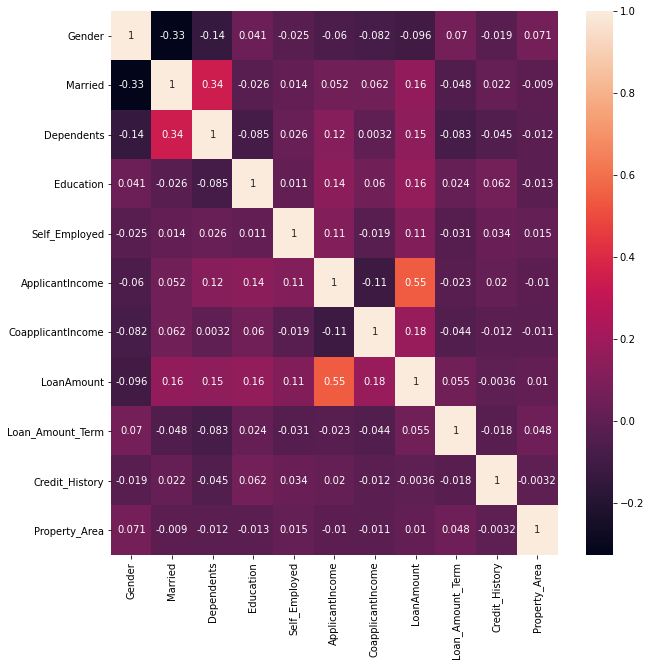

In [17]:
plt.figure(figsize=(10, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show

In [18]:
data['TotalIncome'] = data['ApplicantIncome']+data['CoapplicantIncome']

In [19]:
r = 0.00833
data['EMI'] = data.apply(lambda x: (x['LoanAmount']*r*((1+r)**x['Loan_Amount_Term']))/((1+r)**((x['Loan_Amount_Term'])-1)), axis=1)

In [20]:
data['Dependents_EMI_mean'] = data.groupby(['Dependents'])['EMI'].transform('mean')

data['LoanAmount_per_TotalIncome'] = data['LoanAmount']/data['TotalIncome']

data['Loan_Amount_Term_per_TotalIncome'] = data['Loan_Amount_Term']/data['TotalIncome']

data['EMI_per_Loan_Amount_Term'] = data['EMI']/data['Loan_Amount_Term']

data['EMI_per_LoanAmount'] = data['EMI']/data['LoanAmount']

data['Property_Area_LoanAmount_per_TotalIncome_mean'] = data.groupby(['Property_Area'])['LoanAmount_per_TotalIncome'].transform('mean')

data['Credit_History_Income_Sum'] = data.groupby(['Credit_History'])['TotalIncome'].transform('sum')

data['Dependents_LoanAmount_Sum'] = data.groupby(['Dependents'])['LoanAmount'].transform('sum')

In [21]:
data.Loan_Amount_Term.isnull().sum()

0

In [22]:
from sklearn.preprocessing import KBinsDiscretizer

Loan_Amount_Term_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
data['Loan_Amount_Term_Bins'] = Loan_Amount_Term_discretizer.fit_transform(data['Loan_Amount_Term'].values.reshape(-1,1)).astype(float)

TotalIncome_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
data['TotalIncome_Bins'] = TotalIncome_discretizer.fit_transform(data['TotalIncome'].values.reshape(-1,1)).astype(float)

LoanAmount_per_TotalIncome_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
data['LoanAmount_per_TotalIncome_Bins'] = LoanAmount_per_TotalIncome_discretizer.fit_transform(data['LoanAmount_per_TotalIncome'].values.reshape(-1,1)).astype(float)

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [23]:
data = data.drop(['EMI'], axis=1)
data = data.drop(['TotalIncome'], axis=1)
data = data.drop(['LoanAmount_per_TotalIncome'], axis=1)

In [24]:
data.shape

(981, 22)

In [25]:
new_train = data.iloc[:614]
new_test = data.iloc[614:]

In [26]:
print(new_train.shape)
print(new_test.shape)

(614, 22)
(367, 22)


In [27]:
new_train['Loan_Status'] = new_train['Loan_Status'].map({'N': 0, 'Y': 1}).astype(int)

<ipython-input-27-0e616e2878cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train['Loan_Status'] = new_train['Loan_Status'].map({'N': 0, 'Y': 1}).astype(int)


In [28]:
new_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,...,Dependents_EMI_mean,Loan_Amount_Term_per_TotalIncome,EMI_per_Loan_Amount_Term,EMI_per_LoanAmount,Property_Area_LoanAmount_per_TotalIncome_mean,Credit_History_Income_Sum,Dependents_LoanAmount_Sum,Loan_Amount_Term_Bins,TotalIncome_Bins,LoanAmount_per_TotalIncome_Bins
0,0,0,0,1,0,5849,0.0,142.51153,360.0,1,...,1.123016,0.061549,0.003325,0.008399,0.023615,5.678538e+06,76210.184486,1.0,2.0,2.0
1,0,1,1,1,0,4583,1508.0,128.00000,360.0,1,...,1.252615,0.059104,0.002986,0.008399,0.023982,5.678538e+06,23861.069182,1.0,3.0,1.0
2,0,1,0,1,1,3000,0.0,66.00000,360.0,1,...,1.123016,0.120000,0.001540,0.008399,0.023615,5.678538e+06,76210.184486,1.0,0.0,1.0
3,0,1,0,0,0,2583,2358.0,120.00000,360.0,1,...,1.123016,0.072860,0.002800,0.008399,0.023615,5.678538e+06,76210.184486,1.0,2.0,2.0
4,0,0,0,1,0,6000,0.0,141.00000,360.0,1,...,1.123016,0.060000,0.003290,0.008399,0.023615,5.678538e+06,76210.184486,1.0,3.0,2.0


In [29]:
X = new_train.drop('Loan_Status', axis=1)
y = new_train['Loan_Status']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape

(429, 21)

In [31]:
log_clf = LogisticRegression()
cross_val_score(log_clf, X_train, y_train, cv=3)

array([0.77622378, 0.8041958 , 0.76223776])

In [32]:
predictions = log_clf.fit(X_train, y_train).predict(X_test)
accuracy_score(predictions, y_test)

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.827027027027027

In [33]:
clf = log_clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8018648018648019, 0.827027027027027)

In [34]:
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty':['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
LR_search = GridSearchCV(LogisticRegression(), LRparam_grid, refit=True, verbose=3, cv=5)
LR_search.fit(X_train, y_train)
LR_search.score(X_test, y_test)

Fitting 5 folds for each of 490 candidates, totalling 2450 fits
[CV 1/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.001, max_iter=100, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarn

[CV 2/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.2s
[CV 3/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=100, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=100, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, pena

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END C=0.001, max_iter=100, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=200, penalty=l1, solver=l

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=0.001, max_iter=200, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=0.001, max_iter=200, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.001, max_iter=200, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.001, max_iter=200, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.001, max_iter=200, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.001, max_iter=200, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.2s
[CV 1/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=200, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=200, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=200, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=200, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=200, pena

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.001, max_iter=200, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=200, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=200, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.001, max_iter=200, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=300, penalty=l1, solver=lbfg

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=300, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=300, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=0.001, max_iter=300, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=0.001, max_iter=300, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.001, max_iter=300, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.001, max_iter=300, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.001, max_iter=300, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.001, max_iter=300, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.5s
[CV 1/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=300, pena

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=300, penalty=l2, solver=sag;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.001, max_iter=300, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.001, max_iter=300, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=300, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.001, max_iter=300, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=300, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=400, penalty=l1, solver=lb

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.001, max_iter=400, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=400, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=0.001, max_iter=400, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=0.001, max_iter=400, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.001, max_iter=400, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.001, max_iter=400, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.001, max_iter=400, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.001, max_iter=400, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.2s
[CV 1/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=400, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=400, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=400, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=400, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=400, pena

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=400, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=400, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=400, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=400, penalty=l2, solver=sag;, score=0.779 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=400, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.001, max_iter=400, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=400, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.001, max_iter=400, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l1, solver=lbfg

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.001, max_iter=500, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.2s
[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, pena

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l2, solver=sag;, score=0.776 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=600, penalty=l1, solver=lbf

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.001, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.001, max_iter=600, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=600, penalty=l1, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.001, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=600, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarn

[CV 1/5] END C=0.001, max_iter=600, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.001, max_iter=600, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.001, max_iter=600, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.001, max_iter=600, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.001, max_iter=600, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.2s
[CV 1/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=600, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=600, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=600, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=600, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=600, pena

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=600, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=600, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=600, penalty=l2, solver=sag;, score=0.776 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=600, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.001, max_iter=600, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=600, penalty=l2, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=700, penalty=l1, solver=libli

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.001, max_iter=700, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=700, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.001, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=0.001, max_iter=700, penalty=l1, solver=saga;, score=0.765 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=0.001, max_iter=700, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.001, max_iter=700, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.001, max_iter=700, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.001, max_iter=700, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.001, max_iter=700, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=700, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=700, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=700, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=700, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=700, pena

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.001, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.001, max_iter=700, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=700, penalty=l2, solver=sag;, score=0.788 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=700, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=700, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.001, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.001, max_iter=700, penalty=l2, solver=saga;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=l1, solver=lbfgs;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linese

[CV 1/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s
[CV 2/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.1s
[CV 3/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarn

[CV 4/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.1s
[CV 5/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=100, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 1/5] END C=0.01, max_iter=100, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l2, solver=sag;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l2, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.01, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=200, penalty=l1, solver=lbfgs;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\line

[CV 1/5] END C=0.01, max_iter=200, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.01, max_iter=200, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.01, max_iter=200, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.01, max_iter=200, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.01, max_iter=200, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.3s
[CV 1/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=200, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=200, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=200, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=200, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=200, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 5/5] END C=0.01, max_iter=200, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=200, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=200, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=200, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.01, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=300, penalty=l1, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=300, penalty=l1, solver=liblinear;, score=0.814 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=300, penalty=l1, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l1, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=300, penalty=l1, solver=liblinea

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.01, max_iter=300, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=300, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.01, max_iter=300, penalty=l1, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=300, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END C=0.01, max_iter=300, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 3/5] END C=0.01, max_iter=300, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.01, max_iter=300, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.01, max_iter=300, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.3s
[CV 1/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=300, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=300, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=300, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=300, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.01, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=300, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=300, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.01, max_iter=300, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=300, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=300, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.01, max_iter=300, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=400, penalty=l1, solver=lbfgs;, score=n

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.01, max_iter=400, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=400, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.01, max_iter=400, penalty=l1, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=400, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END C=0.01, max_iter=400, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 3/5] END C=0.01, max_iter=400, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.01, max_iter=400, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.01, max_iter=400, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.3s
[CV 1/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=400, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=400, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=400, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=400, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=400, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 4/5] END C=0.01, max_iter=400, penalty=l2, solver=sag;, score=0.779 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=400, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.01, max_iter=400, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=400, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.01, max_iter=400, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500, penalty=l1, solver=lbfgs;, score=n

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.01, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.01, max_iter=500, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=0.01, max_iter=500, penalty=l1, solver=saga;, score=0.718 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=0.01, max_iter=500, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.01, max_iter=500, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.01, max_iter=500, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 4/5] END C=0.01, max_iter=500, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.01, max_iter=500, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.8s
[CV 1/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=500, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=500, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.01, max_iter=500, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=500, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l2, solver=sag;, score=0.791 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.01, max_iter=500, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.01, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=600, penalty=l1, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=600, penalty=l1, solver=liblinear;, score=0.814 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=600, penalty=l1, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=600, penalty=l1, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=600, penalty=l1, solver=liblinea

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.01, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=600, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.01, max_iter=600, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.01, max_iter=600, penalty=l1, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=600, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END C=0.01, max_iter=600, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 3/5] END C=0.01, max_iter=600, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.01, max_iter=600, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.01, max_iter=600, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.3s
[CV 1/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=600, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=600, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=600, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=600, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=600, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 2/5] END C=0.01, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.01, max_iter=600, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=600, penalty=l2, solver=sag;, score=0.776 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.01, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.1s
[CV 2/5] END C=0.01, max_iter=600, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=600, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.01, max_iter=600, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, max_iter=700, penalty=l1, solver=lbfgs;, score=n

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.01, max_iter=700, penalty=l1, solver=saga;, score=0.744 total time=   0.1s
[CV 2/5] END C=0.01, max_iter=700, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.01, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.1s
[CV 4/5] END C=0.01, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)


[CV 5/5] END C=0.01, max_iter=700, penalty=l1, solver=saga;, score=0.776 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=0.01, max_iter=700, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.01, max_iter=700, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.01, max_iter=700, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.01, max_iter=700, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.01, max_iter=700, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.3s
[CV 1/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=700, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=700, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=700, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=700, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=700, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.01, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.01, max_iter=700, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=700, penalty=l2, solver=sag;, score=0.788 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.01, max_iter=700, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=700, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.01, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.01, max_iter=700, penalty=l2, solver=saga;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total t

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarn

[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.1s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.1s
[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.1s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(



[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.812 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=sag;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=sag;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total ti

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optim

[CV 1/5] END C=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.2s
[CV 1/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=200, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=200, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=200, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l2, solver=sag;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=200, penalty=l2, solver=sag;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan tota

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, max_iter=300, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=300, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarn

[CV 1/5] END C=0.1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.1s
[CV 1/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=300, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=300, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=300, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=300, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=300, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=300, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=300, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=300, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=300, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total t

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=400, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=400, penalty=l1, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=400, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarn

[CV 1/5] END C=0.1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.2s
[CV 1/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=400, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=400, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=400, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=400, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=400, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, max_iter=400, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=400, penalty=l2, solver=sag;, score=0.779 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=400, penalty=l2, solver=sag;, score=0.776 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=400, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=400, penalty=l2, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=400, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total t

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=500, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, max_iter=500, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=500, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 1/5] END C=0.1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.1s
[CV 1/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=500, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=500, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=500, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=500, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=500, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=500, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=500, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=500, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=500, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=500, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, max_iter=500, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=500, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, max_iter=500, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total ti

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, max_iter=600, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, max_iter=600, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 1/5] END C=0.1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.2s
[CV 1/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=600, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=600, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=600, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=600, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=600, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=600, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=600, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=600, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 2/5] END C=0.1, max_iter=600, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=600, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=600, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total t

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=700, penalty=l1, solver=saga;, score=0.744 total time=   0.1s
[CV 2/5] END C=0.1, max_iter=700, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=0.1, max_iter=700, penalty=l1, solver=saga;, score=0.776 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=0.1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=0.1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.814 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=0.1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=0.1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.1s
[CV 1/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=700, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=700, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=700, penalty=l2, solver=sag;, score=0.788 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=700, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=700, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.1, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, max_iter=700, penalty=l2, solver=saga;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] 

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optim

[CV 3/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarn

[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.1s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.1s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=liblinear;, score=0.812 total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5]

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=200, penalty=l1, solver=liblinear;, score=0.824 total time=   0.0s
[CV 1/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\si

[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.2s
[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l2, solver=liblinear;, score=0.812 total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5]

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, max_iter=300, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=300, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarn

[CV 1/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.2s
[CV 1/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=300, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=300, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=1, max_iter=300, penalty=l2, solver=liblinear;, score=0.812 total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=300, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] 

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=400, penalty=l1, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l1, solver=liblinear;, score=0.824 total time=   0.0s
[CV 1/5] END C=1, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.2s
[CV 1/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.812 total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=sag;, score=0.779 total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 2/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] E

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.733 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.3s
[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.812 total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=sag;, score=0.791 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=600, penalty=l1, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l1, solver=liblinear;, score=0.814 total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l1, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l1, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l1, solver=liblinear;, score=0.824 total time=   0.0s
[CV 1/5] END C=1, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.7s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.2s
[CV 1/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=600, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=liblinear;, score=0.812 total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=sag;, score=0.791 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] E

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=700, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 5/5] END C=1, max_iter=700, penalty=l1, solver=saga;, score=0.776 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarn

[CV 1/5] END C=1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 4/5] END C=1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.791 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.7s
[CV 1/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.812 total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=1, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=700, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=1, max_iter=700, penalty=l2, solver=sag;, score=0.788 total time=   0.0s
[CV 1/5] END C=1, max_iter=700, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1, max_iter=700, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=1, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=700, penalty=l2, solver=saga;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=100, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarn

[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.1s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.1s
[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=200, penalty=l1, solver=liblinear;, score=0.835 total time=   0.0s
[CV 1/5] END C=10, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarn

[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.2s
[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=200, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=200, penalty=l2, solver=liblinear;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=300, penalty=l1, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l1, solver=liblinear;, score=0.802 total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l1, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=300, penalty=l1, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l1, solver=liblinear;, score=0.835 total time=   0.0s
[CV 1/5] END C=10, max_iter=300, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=300, penalty=l1, solver=sag;, score=nan total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarn

[CV 1/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=300, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=300, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l2, solver=liblinear;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.767 total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 4/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10, max_iter=400, penalty=l1, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l1, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l1, solver=liblinear;, score=0.835 total time=   0.0s
[CV 1/5] END C=10, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l1, solver=sag;, score=nan total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.733 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.767 total time=   0.1s
[CV 4/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.7s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.2s
[CV 1/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=400, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l2, solver=liblinear;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l2, solver=sag;, score=0.779 total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l2, solver=sag;, score=0.776 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10, max_iter=500, penalty=l1, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l1, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=liblinear;, score=0.835 total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 2/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=liblinear;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=sag;, score=0.791 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=600, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=600, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=600, penalty=l2, solver=liblinear;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=600, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=600, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=600, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=600, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=10, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=600, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=700, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l1, solver=saga;, score=0.776 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarn

[CV 1/5] END C=10, max_iter=700, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=10, max_iter=700, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=sag;, score=0.791 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=sag;, score=0.788 total time=   0.0s
[CV 1/5] END C=10, max_iter=700, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=700, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=saga;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total tim

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=100, penalty=l1, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l1, solver=liblinear;, score=0.824 total time=   0.0s
[CV 1/5] END C=100, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=100, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarn

[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.1s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarn

[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.1s
[CV 1/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.4s
[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=sag;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.733 total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 3/5] END C=100, max_iter=300, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l1, solver=saga;, score=0.718 total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.2s
[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=400, penalty=l1, solver=lbfgs;, score=nan tota

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.2s
[CV 1/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=400, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=400, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=400, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=400, penalty=l2, solver=sag;, score=0.779 total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=500, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=500, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=500, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=500, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=500, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total ti

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 3/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=600, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=600, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=600, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total t

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=700, penalty=l1, solver=liblinear;, score=0.779 total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l1, solver=liblinear;, score=0.812 total time=   0.0s
[CV 1/5] END C=100, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l1, solver=sag;, score=nan total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=700, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=100, max_iter=700, penalty=l1, solver=saga;, score=0.776 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=100, max_iter=700, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=100, max_iter=700, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=100, max_iter=700, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=100, max_iter=700, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=700, penalty=l2, solver=newton-cg;, score=0.812 total time=   0.1s
[CV 1/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=100, max_iter=700, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l2, solver=libline

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=700, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l2, solver=sag;, score=0.788 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=700, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l2, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=700, penalty=l2, solver=saga;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=100, penalty=l1, solver=lbfgs;, score=na

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning:

[CV 3/5] END C=1000, max_iter=100, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1000, max_iter=100, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, max_iter=100, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.1s
[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarn

[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.1s
[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.824 total time=   0.1s
[CV 1/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=100, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=100, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 1/5] END C=1000, max_iter=100, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=sag;, score=0.767 total time=   0.0s
[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, max_iter=100, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.767 total time=   0.0s

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l1, solver=lbfgs;, score

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=200, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, max_iter=200, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 1/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.835 total time=   0.3s
[CV 1/5] END C=1000, max_iter=200, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=200, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=200, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=200, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=200, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=200, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 5/5] END C=1000, max_iter=200, penalty=l2, solver=sag;, score=0.718 total time=   0.0s
[CV 1/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=n

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 1/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.835 total time=   0.5s
[CV 1/5] END C=1000, max_iter=300, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=300, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=300, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=300, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l1, solver=lbfgs;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=400, penalty=l1, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l1, solver=saga;, score=0.767 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=400, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, max_iter=400, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 1/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.835 total time=   0.4s
[CV 1/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=400, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=400, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=400, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l2, solver=sag;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=400, penalty=l2, solver=sag;, score=0.779 total time=   0.0s
[CV 5/5] END C=1000, max_iter=400, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=n

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.733 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.718 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.835 total time=   0.5s
[CV 1/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=500, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=500, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=500, penalty=l2, solver=sag;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.767 total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.744 total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=600, penalty=l1, solver=lbfgs;, scor

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=600, penalty=l1, solver=sag;, score=nan total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.733 total time=   0.2s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.756 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.744 total time=   0.2s
[CV 5/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.718 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\

[CV 1/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.5s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.835 total time=   0.5s
[CV 1/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=600, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=600, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=600, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=600, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=600, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=600, penalty=l2, solver=sag;, score=0.744 total time=   0.1s
[CV 2/5] END C=1000, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1000, max_iter=600, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=1000, max_iter=600, penalty=l2, solver=sag;, score=0.791 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=600, penalty=l2, solver=sag;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.744 total time=   0.1s
[CV 5/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.718 total time=   0.0s
[CV 1/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=700, penalty=l1, solver=lbfgs;, score=

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=700, penalty=l1, solver=saga;, score=0.744 total time=   0.1s
[CV 2/5] END C=1000, max_iter=700, penalty=l1, solver=saga;, score=0.733 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1000, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.1s
[CV 4/5] END C=1000, max_iter=700, penalty=l1, solver=saga;, score=0.756 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 5/5] END C=1000, max_iter=700, penalty=l1, solver=saga;, score=0.776 total time=   0.1s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 1/5] END C=1000, max_iter=700, penalty=l2, solver=newton-cg;, score=0.744 total time=   0.6s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 2/5] END C=1000, max_iter=700, penalty=l2, solver=newton-cg;, score=0.802 total time=   0.4s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 3/5] END C=1000, max_iter=700, penalty=l2, solver=newton-cg;, score=0.837 total time=   0.3s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV 4/5] END C=1000, max_iter=700, penalty=l2, solver=newton-cg;, score=0.779 total time=   0.7s


C:\Users\Hp\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=700, penalty=l2, solver=newton-cg;, score=0.835 total time=   0.5s
[CV 1/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.776 total time=   0.0s
[CV 1/5] END C=1000, max_iter=700, penalty=l2, solver=liblinear;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=700, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1000, max_iter=700, penalty=l2, solver=liblinear;, score=0.837 total time=   0.0s
[CV 4/5] END C=1000, max_iter=700, penalty=l2, solver=liblinear;, score=0.791 total time=   0.0s
[CV 5/5] END C=1000, max_iter=700, penalty=l2, sol

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=700, penalty=l2, solver=sag;, score=0.744 total time=   0.0s
[CV 2/5] END C=1000, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1000, max_iter=700, penalty=l2, solver=sag;, score=0.756 total time=   0.0s
[CV 4/5] END C=1000, max_iter=700, penalty=l2, solver=sag;, score=0.791 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=700, penalty=l2, solver=sag;, score=0.788 total time=   0.0s
[CV 1/5] END C=1000, max_iter=700, penalty=l2, solver=saga;, score=0.744 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=700, penalty=l2, solver=saga;, score=0.733 total time=   0.0s
[CV 3/5] END C=1000, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
735 fits failed out of a total of 2450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
245 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimato

[CV 4/5] END C=1000, max_iter=700, penalty=l2, solver=saga;, score=0.756 total time=   0.0s
[CV 5/5] END C=1000, max_iter=700, penalty=l2, solver=saga;, score=0.776 total time=   0.0s


0.8324324324324325

In [35]:
LR_search.best_score_

0.8019425444596443

In [36]:
LR_search.best_params_

{'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [37]:
import warnings
warnings.filterwarnings('ignore')

clf = LogisticRegression(C=100, max_iter=200, penalty='l1', solver='liblinear')
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.8041958041958042, 0.8432432432432433)

<AxesSubplot:>

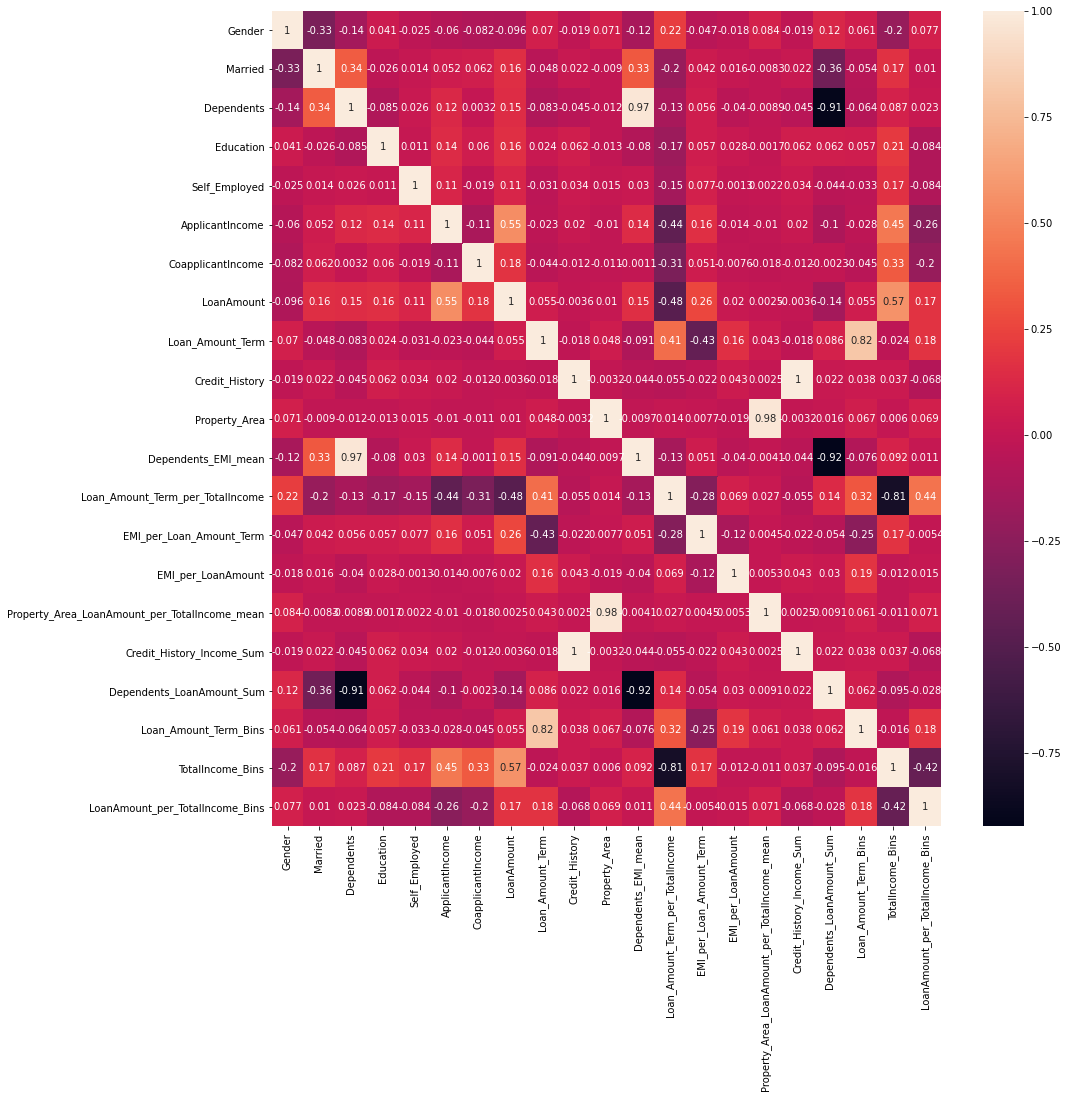

In [38]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True)